In [ ]:
!pip install moku[neuralnetwork]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.3/91.3 kB 6.2 MB/s eta 0:00:00


# Approximating a Small DFT Using the Moku Neural Network

In this tutorial we demonstrate how to use the Moku neural network library to train a model that approximates a discrete Fourier transform (DFT).

We will:
1. Generate random signals in the time domain.
2. Compute their (normalized) DFT using NumPy.
3. Train a single-layer, linear Moku neural network to map the time-domain samples to the real and imaginary parts of a few low-frequency DFT bins.
4. Evaluate and visualize how well the network learned the DFT.
5. Save the trained model to a `.linn` file for use with the Moku Neural Network instrument.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from moku.nn import LinnModel, save_linn

# Set the seed for reproducibility
np.random.seed(42)

/usr/local/lib/python3.12/dist-packages/moku/__init__.py:30: UserWarning: Can't find mokucli, which is required for correct operation. Please install from https://liquidinstruments.com/software/utilities/ or set the MOKU_CLI_PATH environment variable to the path of the mokucli executable. Using default path.
  warnings.warn(


## Step 1: Generate training data

We will generate short, real-valued time-domain signals as our inputs. Each signal is a sum of a few sinusoids at different discrete frequency bins, with random amplitudes and phases.

For each signal:
- Input **x** has shape `(N_SAMPLES,)` (time samples).
- Target output **y** is a vector containing the real and imaginary parts of
  the first `N_BINS` DFT bins:
$
   y = [Re(X[0]), \ldots, Re(X[N\_BINS-1]),
        Im(X[0]), \ldots, Im(X[N\_BINS-1])]
$

This mapping is linear, so a single dense layer with linear activation is theoretically sufficient to implement it exactly.

In [ ]:
# Parameters for the synthetic DFT learning problem
N_SAMPLES = 16          # Number of time-domain samples in each signal
N_BINS = 4              # Number of low-frequency DFT bins we will learn
N_OUTPUTS = 2 * N_BINS  # Real + Imag for each bin
N_SIGNALS = 4096        # Number of training examples

n = np.arange(N_SAMPLES)

def random_signal(n):
    """
    Generate a random real-valued signal as a sum of a few sinusoids whose frequencies are among the first N_BINS DFT bins.
    """
    num_components = np.random.randint(1, 4)  # 1–3 sinusoids
    s = np.zeros_like(n, dtype=np.float32)

    for _ in range(num_components):
        # Pick a discrete frequency bin within the range we care about
        k = np.random.randint(0, N_BINS)
        amp = np.random.uniform(0.2, 1.0)
        phase = np.random.uniform(0, 2 * np.pi)
        s += amp * np.sin(2 * np.pi * k * n / N_SAMPLES + phase)

    # Add a bit of noise
    noise = 0.02 * np.random.randn(len(n))
    s = s + noise.astype(np.float32)

    return s

In [ ]:
# Allocate arrays for input (time-domain) and output (DFT) data
X_train = np.zeros((N_SIGNALS, N_SAMPLES), dtype=np.float32)
Y_train = np.zeros((N_SIGNALS, N_OUTPUTS), dtype=np.float32)

for i in range(N_SIGNALS):
    sig = random_signal(n)
    X_train[i, :] = sig

    # Normalized DFT (divide by N to keep coefficient magnitudes ~ amplitudes)
    fft = np.fft.rfft(sig) / N_SAMPLES  # shape (N_SAMPLES/2 + 1,)

    # Keep only the first N_BINS bins for training
    fft_bins = fft[:N_BINS]

    # Pack real and imaginary parts into a single real-valued target vector
    Y_train[i, :N_BINS] = np.real(fft_bins)
    Y_train[i, N_BINS:] = np.imag(fft_bins)

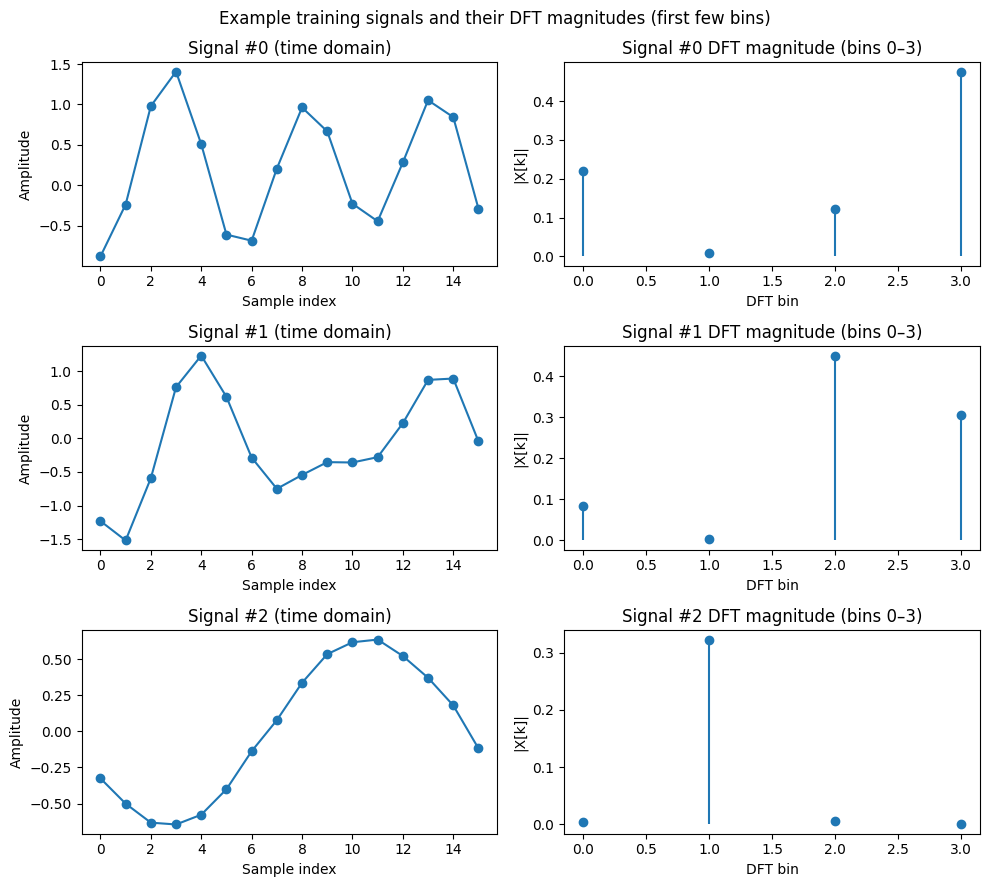

In [ ]:
# Plot a couple of example signals and their DFT magnitudes
num_examples_to_plot = 3

fig, axes = plt.subplots(num_examples_to_plot, 2, figsize=(10, 3 * num_examples_to_plot))
fig.suptitle("Example training signals and their DFT magnitudes (first few bins)")

for idx in range(num_examples_to_plot):
    sig = X_train[idx, :]
    fft = np.fft.rfft(sig) / N_SAMPLES
    fft_bins = fft[:N_BINS]

    # Time-domain
    axes[idx, 0].plot(n, sig, marker='o')
    axes[idx, 0].set_title(f"Signal #{idx} (time domain)")
    axes[idx, 0].set_xlabel("Sample index")
    axes[idx, 0].set_ylabel("Amplitude")

    # Magnitude of first N_BINS DFT bins
    axes[idx, 1].stem(np.arange(N_BINS), np.abs(fft_bins), basefmt=" ")
    axes[idx, 1].set_title(f"Signal #{idx} DFT magnitude (bins 0–{N_BINS-1})")
    axes[idx, 1].set_xlabel("DFT bin")
    axes[idx, 1].set_ylabel("|X[k]|")

plt.tight_layout()
plt.show()

## Step 2: Define the model and prepare training data
- Each training example is a vector of length `N_SAMPLES` (time samples).
- Each output is a vector of length `N_OUTPUTS = 2 * N_BINS` (real + imaginary parts).

In [ ]:
linn_model = LinnModel()

# Set the training data. Shape: (N, N_SAMPLES) → (N, 2*N_BINS)
linn_model.set_training_data(X_train, Y_train, scale=False)

print("Input shape:", X_train.shape)
print("Output shape:", Y_train.shape)

Input shape: (4096, 16)
Output shape: (4096, 8)


## Step 3: Construct a linear model for the DFT mapping

A DFT is a linear transform:

$
  \mathbf{Y} = \mathbf{W}\mathbf{x}
$

so we can represent it with a *single* dense layer and a linear activation.
The layer size is the number of outputs we need (`2 * N_BINS`).

In [ ]:
model_definition = [
    (N_OUTPUTS, 'linear')  # real + imag for each of the N_BINS
]

linn_model.construct_model(model_definition)

linn_model.model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer               │ (None, 8)              │             0 │
│ (OutputClipLayer)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136 (544.00 B)

 Trainable params: 136 (544.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/800
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3828 - val_loss: 0.2605
Epoch 2/800
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1957 - val_loss: 0.0785
Epoch 3/800
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0547 - val_loss: 0.0156
Epoch 4/800
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105 - val_loss: 0.0029
Epoch 5/800
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020 - val_loss: 7.2671e-04
Epoch 6/800
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.5292e-04 - val_loss: 4.1196e-04
Epoch 7/800
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9912e-04 - val_loss: 3.7601e-04
Epoch 8/800
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5501e-04 - val_loss: 3.7123e-04
Epoch 9/800
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5014e-04 - val_loss: 3.7092e-04
Epoch 10/800
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1214e-04 - val_loss: 3.6929e-04
Epoch 11/800
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3219e-04 - val_loss: 

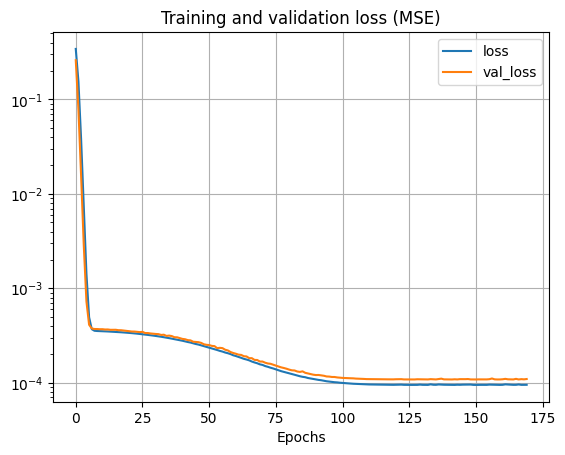

In [ ]:
history = linn_model.fit_model(
    epochs=800,
    validation_split=0.1,
    es_config={'patience': 20}
)

# Plot the training and validation loss
plt.figure()
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.title('Training and validation loss (MSE)')
plt.grid(True)
plt.show()

## Step 4: Evaluate the model on new signals

To verify that the model has learned the DFT mapping (and not just memorized the training set), we will:

1. Generate a fresh test set of random signals.
2. Compute the "true" DFT coefficients using NumPy.
3. Compare the model outputs with the true coefficients.
4. Visualize both the real and imaginary parts, as well as magnitudes.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean squared error on complex DFT coefficients: 8.512342e-05


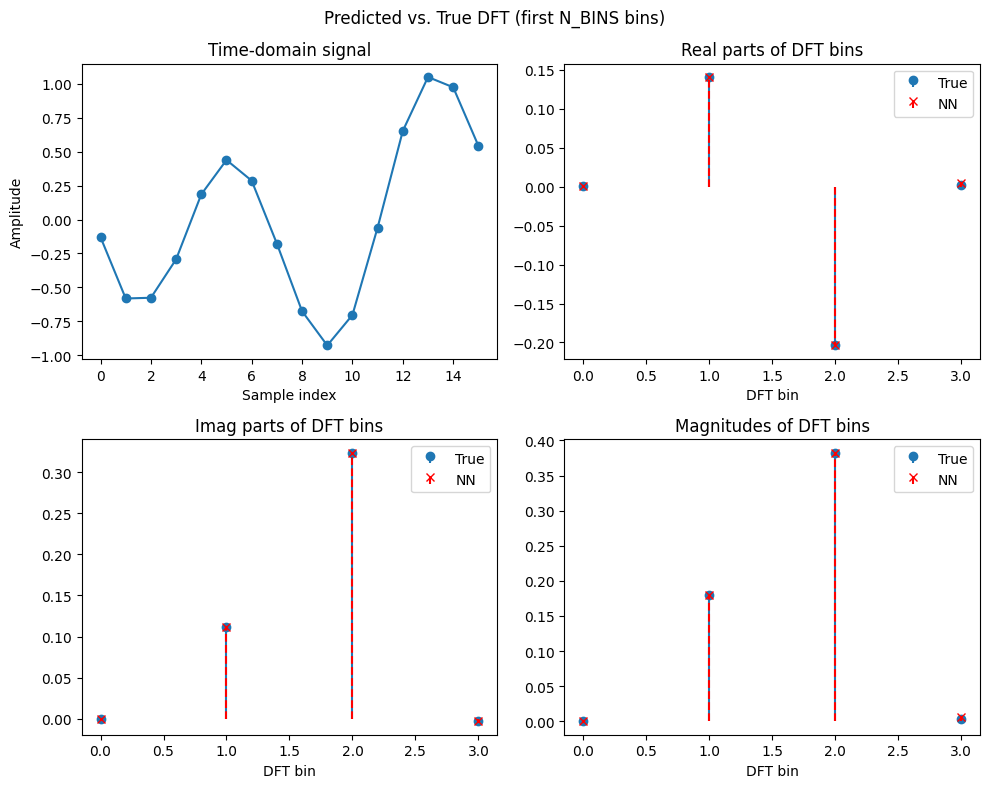

In [ ]:
# Generate a separate test set
N_TEST = 256

X_test = np.zeros((N_TEST, N_SAMPLES), dtype=np.float32)
Y_test = np.zeros((N_TEST, N_OUTPUTS), dtype=np.float32)

for i in range(N_TEST):
    sig = random_signal(n)
    X_test[i, :] = sig
    fft = np.fft.rfft(sig) / N_SAMPLES
    fft_bins = fft[:N_BINS]
    Y_test[i, :N_BINS] = np.real(fft_bins)
    Y_test[i, N_BINS:] = np.imag(fft_bins)

# Model predictions
Y_pred = linn_model.predict(X_test)

def unpack_complex(y):
    """
    Convert a (N, 2*N_BINS) real matrix into complex DFT coefficients shaped (N, N_BINS).
    """
    real = y[:, :N_BINS]
    imag = y[:, N_BINS:]
    return real + 1j * imag

Y_test_complex = unpack_complex(Y_test)
Y_pred_complex = unpack_complex(Y_pred)

# Compute overall mean squared error on the complex coefficients
mse = np.mean(np.abs(Y_test_complex - Y_pred_complex)**2)
print(f"Mean squared error on complex DFT coefficients: {mse:.6e}")

# Visualize one example
example_idx = 0

sig = X_test[example_idx, :]
true_fft = Y_test_complex[example_idx, :]
pred_fft = Y_pred_complex[example_idx, :]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Predicted vs. True DFT (first N_BINS bins)")

# Time-domain signal
axes[0, 0].plot(n, sig, marker='o')
axes[0, 0].set_title("Time-domain signal")
axes[0, 0].set_xlabel("Sample index")
axes[0, 0].set_ylabel("Amplitude")

# Real parts
axes[0, 1].stem(np.arange(N_BINS), np.real(true_fft), linefmt='-', markerfmt='o', basefmt=" ")
axes[0, 1].stem(np.arange(N_BINS), np.real(pred_fft), linefmt='--r', markerfmt='x', basefmt=" ")
axes[0, 1].set_title("Real parts of DFT bins")
axes[0, 1].set_xlabel("DFT bin")
axes[0, 1].legend(["True", "NN"])

# Imag parts
axes[1, 0].stem(np.arange(N_BINS), np.imag(true_fft), linefmt='-', markerfmt='o', basefmt=" ")
axes[1, 0].stem(np.arange(N_BINS), np.imag(pred_fft), linefmt='--r', markerfmt='x', basefmt=" ")
axes[1, 0].set_title("Imag parts of DFT bins")
axes[1, 0].set_xlabel("DFT bin")
axes[1, 0].legend(["True", "NN"])

# Magnitudes
axes[1, 1].stem(np.arange(N_BINS), np.abs(true_fft), linefmt='-', markerfmt='o', basefmt=" ")
axes[1, 1].stem(np.arange(N_BINS), np.abs(pred_fft), linefmt='--r', markerfmt='x', basefmt=" ")
axes[1, 1].set_title("Magnitudes of DFT bins")
axes[1, 1].set_xlabel("DFT bin")
axes[1, 1].legend(["True", "NN"])

plt.tight_layout()
plt.show()

These four plots compare our neural network's predicted DFT with the true DFT of a time-domain signal, allowing for a comprehensive evaluation of the model's accuracy. The top-left plot displays the original input signal over time. The next two plots (top-right and bottom-left), showing the real (cosine) and imaginary (sine) parts of the DFT, reveal how accurately the NN captures the phase information at each frequency bin. Here, overlapping red (NN prediction) and blue (true) markers indicate correct phase prediction. Finally, the bottom-right plot compares the magnitude (strength) of each frequency compononent, with a close alignment between the red and blue markers indicating that the NN has learned the correct frequency content of the signal. In all frequency domain plots, the closer the red predictions are to the blue true values, the more accurate the model's output.

## Step 6: Inspect learned weights

Because the DFT is a linear transform, we expect the trained weights to resemble the analytical DFT matrix.

The output $Y$ of a linear layer (or dense layer) in a neural network is computed as:

$$
Y = WX + B
$$
Where:
- $X$ is the input vector.
- $W$ is the weight matrix.
- $B$ is the bias vector (often zero for this application).

Comparing this to the DFT formula:
$$
X[k] = \sum_{n=0}^{N_{SAMPLES}-1} x[n] e^{-j 2\pi kn / N_{SAMPLES}}
$$

Here,
- The input signal vector $x$ corresponds to the input vector $X$ to the neural network.
- The output DFT coefficients vector $X$ corresponds to the output $Y$ of the linear layer.
- The weight matrix $W$ of the neural network's dense layer becomes the DFT matrix, where each element $W_{kn}$ is given by the complex exponential term $e^{-j2\pi kn/N_{SAMPLES}}$.

After training, the rows of the dense layer weight matrix should look like cosines (for real parts) and negative sines (for imaginary parts) over $n$.

To understand more on how the DFT matrix is computed, please see: https://en.wikipedia.org/wiki/Discrete_Fourier_transform

Dense layer weight matrix shape: (16, 8)
Dense layer bias shape: (8,)


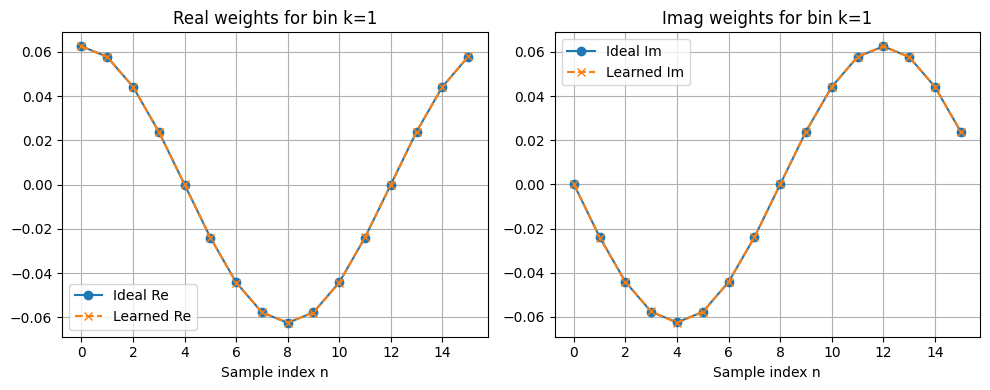

In [ ]:
# Extract first Dense layer weights and biases
layer_index = 1  # 0 is InputLayer, 1 should be the Dense layer
dense_layer = history.model.layers[layer_index]
W, b = dense_layer.get_weights()  # W shape: (N_SAMPLES, N_OUTPUTS)

print("Dense layer weight matrix shape:", W.shape)
print("Dense layer bias shape:", b.shape)

# For convenience, transpose to shape (N_OUTPUTS, N_SAMPLES):
W_T = W.T

# Compare the learned weights for a couple of bins to the ideal DFT coefficients
k_to_inspect = 1  # e.g. DFT bin 1

ideal = np.exp(-2j * np.pi * k_to_inspect * n / N_SAMPLES) / N_SAMPLES
ideal_real = np.real(ideal)
ideal_imag = np.imag(ideal)

learned_real = W_T[k_to_inspect, :]  # row corresponding to Re{X[k]}
learned_imag = W_T[N_BINS + k_to_inspect, :]  # row corresponding to Im{X[k]}

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(n, ideal_real, 'o-', label='Ideal Re')
plt.plot(n, learned_real, 'x--', label='Learned Re')
plt.title(f"Real weights for bin k={k_to_inspect}")
plt.xlabel("Sample index n")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(n, ideal_imag, 'o-', label='Ideal Im')
plt.plot(n, learned_imag, 'x--', label='Learned Im')
plt.title(f"Imag weights for bin k={k_to_inspect}")
plt.xlabel("Sample index n")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Step 6: Save the model for later use

In [ ]:
# Save the trained model to a .linn file
linn_filename = f"DFT_{N_SAMPLES}samples_{N_BINS}bins.linn"
save_linn(
    linn_model.model,
    input_channels=1,
    output_channels=1,
    file_name=linn_filename
)

Skipping layer 0 with type <class 'keras.src.layers.core.input_layer.InputLayer'>
Skipping layer 2 with type <class 'moku.nn._linn.OutputClipLayer'>
Network latency approx. 19 cycles


# Observations

Although the model was trained to output DFT coefficients, when it is deployed in the Moku Neural Network instrument it runs in **serial mode**: with a single physical input channel and many input neurons, each new sample is ingested as part of a sliding window of the last $N$ points (in our case $N = 16$). Every inference therefore measures how strongly that window matches the learned low-frequency Fourier patterns, which is mathematically equivalent to running a small bank of **FIR filters**!

**Sample FIR Filter Diagram:**

![Sample FIR Filter Diagram](https://drive.google.com/uc?export=view&id=1Mzb8fTf_jvJnog9zgFwQYzDCi_nxs5HC)

These filters use linear convolution on finite input samples for a desired frequency response. Their main priorities are guaranteed stability and a linear phase response, which ensures all frequency components are delayed equally to preserve the signal's waveform.

The output thus behaves like an $N$-point **moving-average filter**, while the other low-frequency bins act as smooth oscillation filters. Our pulse waveform is dominated by low-frequency content, so these outputs track the clean signal very well, whereas the noise (spread over many frequencies and rapidly changing sign across the window) tends to cancel out. When we plot these low-frequency outputs on the oscilloscope, the network effectively behaves like a **DFT-derived low-pass filter**, giving what looks like a clean reconstruction of the original signal even though no explicit inverse DFT step is being performed!


**The input noisy signal into the NN (blue) + the output from our DFT NN (red):**

![Noisy + DFT](https://drive.google.com/uc?export=view&id=1gRfETm7odOwUr1B8uotMc7I51tCbnedc)

**The pure signal (blue) + the output from our DFT NN (red):**

![Pure + DFT](https://drive.google.com/uc?export=view&id=1NcvoDoG8riG1jHm8KHb1C4-D17gE6LF-)
